In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from parse import parse

from alphaMusic.utils.fls_utils import load_from_pkl
import alphaMusic.evaluation as evl

In [3]:
path_to_results = Path('..','recipes','EUSIPCO22','results')
assert path_to_results.exists()

files = path_to_results.glob('auditorium*.pkl')
exp_name = 'auditorium_N:{n_samples}_RT60:{rt60_name}_SNR:{snr_name}_DRR:{drr_name}_nsrcs:{n_srcs}_nmics:{n_mics}_noise:{noise_type}'

results = pd.DataFrame()
for file in files:
    print(file)
    params = parse(exp_name,str(file.name))
    df = load_from_pkl(file)
    df['n_mics'] = int(params['n_mics'])
    df['n_srcs'] = int(params['n_srcs'])
    results = pd.concat([results, df], ignore_index=True)

../recipes/EUSIPCO22/results/auditorium_N:180_RT60:sweep_SNR:10_DRR:2.5_nsrcs:3_nmics:4_noise:living_results.pkl
../recipes/EUSIPCO22/results/auditorium_N:180_RT60:sweep_SNR:10_DRR:2.5_nsrcs:1_nmics:4_noise:living_results.pkl
../recipes/EUSIPCO22/results/auditorium_N:180_RT60:sweep_SNR:10_DRR:2.5_nsrcs:2_nmics:4_noise:living_results.pkl
../recipes/EUSIPCO22/results/auditorium_N:180_RT60:sweep_SNR:10_DRR:2.5_nsrcs:4_nmics:4_noise:living_results.pkl


In [4]:
df = pd.DataFrame()

for r, row in results.iterrows():
    
    # compute metrics
    doas_est = row['DOAs_est']
    doas_ref = row['DOAs']
    
    metrics = evl.compute_ssl_metrics(doas_est, doas_ref)
    
    df.at[r,'algo'] = row['algo']

    df.at[r,'MAE'] = metrics['MAE']
    df.at[r,'RMSE'] = metrics['RMSE']
    df.at[r,'ACC5'] = metrics['ACC5']
    df.at[r,'ACC10'] = metrics['ACC10']
    df.at[r,'MISS'] = metrics['MISS']
    
    # params
    df.at[r,'SNR'] = row['SNR']
    df.at[r,'RT60'] = row['RT60']
    df.at[r,'n_mics'] = row['n_mics']
    df.at[r,'n_srcs'] = row['n_srcs']

In [5]:
df

,algo,MAE,RMSE,ACC5,ACC10,MISS,SNR,RT60,n_mics,n_srcs
0,MUSIC,12.666667,14.537308,33.333333,33.333333,0.0,10.0,2.5,4.0,3.0
1,aMUSIC_est,17.666667,20.856654,0.000000,33.333333,0.0,10.0,2.5,4.0,3.0
2,aMUSIC_fix,24.000000,24.993332,0.000000,0.000000,0.0,10.0,2.5,4.0,3.0
3,NormMUSIC,19.000000,19.891372,0.000000,0.000000,0.0,10.0,2.5,4.0,3.0
4,aNormMUSIC_est,19.333333,20.816660,0.000000,0.000000,0.0,10.0,2.5,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...
10075,aMUSIC_fix,5.000000,6.442049,50.000000,75.000000,0.0,10.0,1.0,4.0,4.0
10076,NormMUSIC,17.000000,18.452642,0.000000,25.000000,0.0,10.0,1.0,4.0,4.0
10077,aNormMUSIC_est,12.000000,16.248077,50.000000,50.000000,0.0,10.0,1.0,4.0,4.0
10078,aNormMUSIC_fix,11.250000,15.960890,50.000000,50.000000,0.0,10.0,1.0,4.0,4.0


In [6]:
algo_order = ['MUSIC','aMUSIC_est','aMUSIC_fix','NormMUSIC','aNormMUSIC_est','aNormMUSIC_fix','SRP_PHAT']

In [17]:
table_ij_algo = pd.DataFrame()

metric = 'MAE'

c = 0
for J in [1,2,3,4]:
    for algo in algo_order:
        df_selection = df.loc[(df['algo'] == algo) & (df['n_srcs'] == J) ]
        err = np.mean(df_selection[metric])
        std = np.std(df_selection[metric])
            
        table_ij_algo.at[c, 'n_srcs'] = int(J)
        table_ij_algo.at[c, algo] = '%1.2f +- %1.2f' % (err, std)
    c += 1

table_ij_algo

,n_srcs,MUSIC,aMUSIC_est,aMUSIC_fix,NormMUSIC,aNormMUSIC_est,aNormMUSIC_fix,SRP_PHAT
0,1.0,26.42 +- 22.92,29.35 +- 22.72,29.15 +- 22.71,16.18 +- 17.83,16.41 +- 18.01,16.30 +- 17.86,30.57 +- 25.57
1,2.0,24.03 +- 12.07,24.16 +- 11.71,24.12 +- 11.57,14.45 +- 10.54,15.04 +- 10.96,15.13 +- 11.01,20.33 +- 12.67
2,3.0,18.10 +- 6.18,16.90 +- 7.68,17.43 +- 7.37,13.98 +- 6.20,12.73 +- 6.16,12.49 +- 5.81,15.60 +- 8.33
3,4.0,14.53 +- 5.01,14.47 +- 5.13,14.44 +- 5.60,14.34 +- 5.94,14.74 +- 5.29,14.61 +- 5.78,11.99 +- 7.06


In [18]:
sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':1.5,
            'font.family': 'sans-serif',
            'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(7, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
algo_order = ['MUSIC','aMUSIC_est','aMUSIC_fix','NormMUSIC','aNormMUSIC_est','aNormMUSIC_fix','SRP_PHAT']

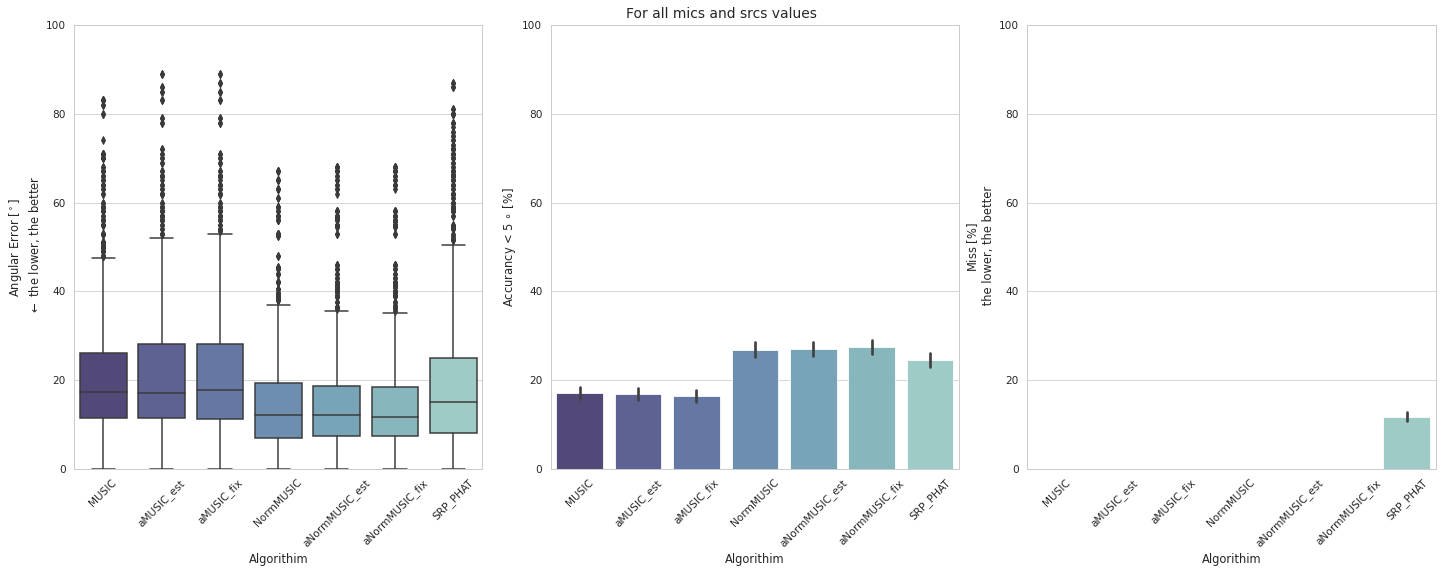

In [19]:
plt.figure(figsize=(20,8))
plt.suptitle('For all mics and srcs values')

plt.subplot(131)
sns.boxplot(x='algo', y='MAE', data=df[['algo','MAE']],
           hue_order=algo_order, palette=pal)
plt.ylim([0,100])
plt.xticks(rotation=45)
plt.ylabel('Angular Error [$^\circ$] \n $\leftarrow$ the lower, the better')
plt.xlabel('Algorithim')

plt.subplot(132)
sns.barplot(x='algo', y='ACC5', data=df[['algo','ACC5']],
           hue_order=algo_order, palette=pal)
plt.ylim([0,100])
plt.xticks(rotation=45)
plt.ylabel('Accurancy < 5 $\circ$ [$\%$]')
plt.xlabel('Algorithim')

plt.subplot(133)
sns.barplot(x='algo', y='MISS', data=df[['algo','MISS']],
           hue_order=algo_order, palette=pal)
plt.ylim([0,100])
plt.xticks(rotation=45)
plt.ylabel('Miss [$\%$] \n the lower, the better')
plt.xlabel('Algorithim')

# sns.despine(offset=10, trim=False, left=True, bottom=True)
plt.tight_layout(pad=0.5)
plt.show()

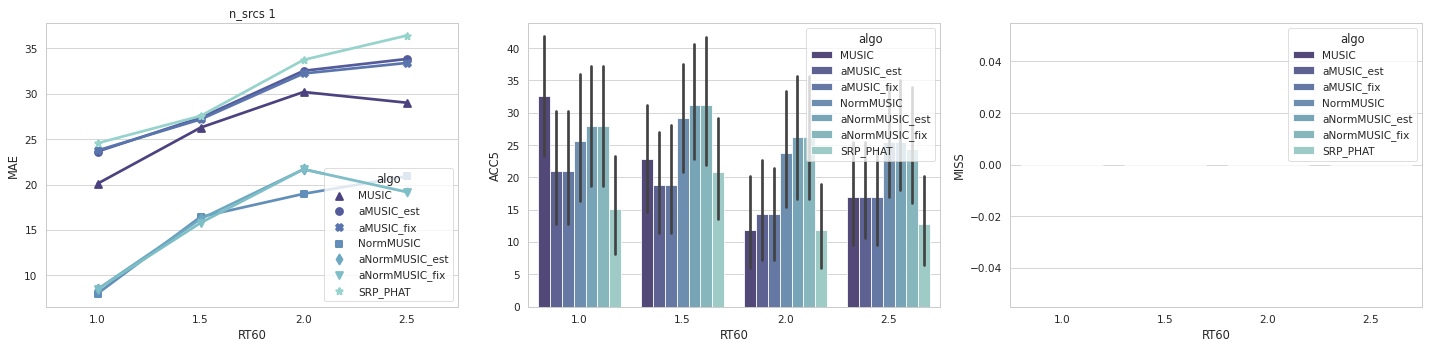

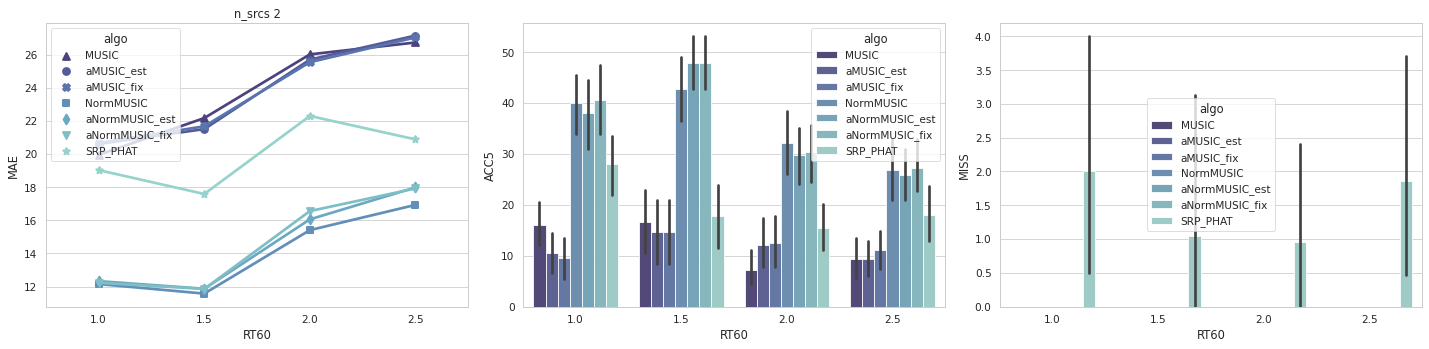

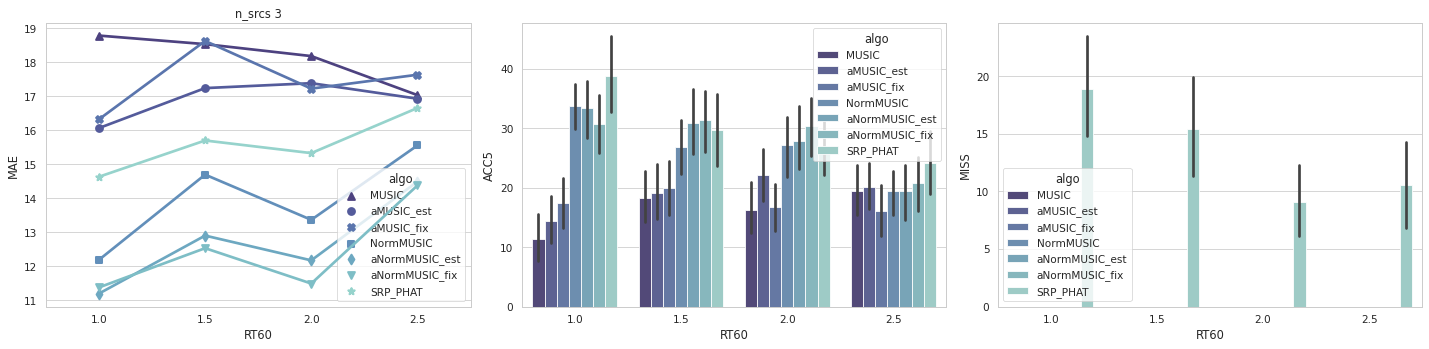

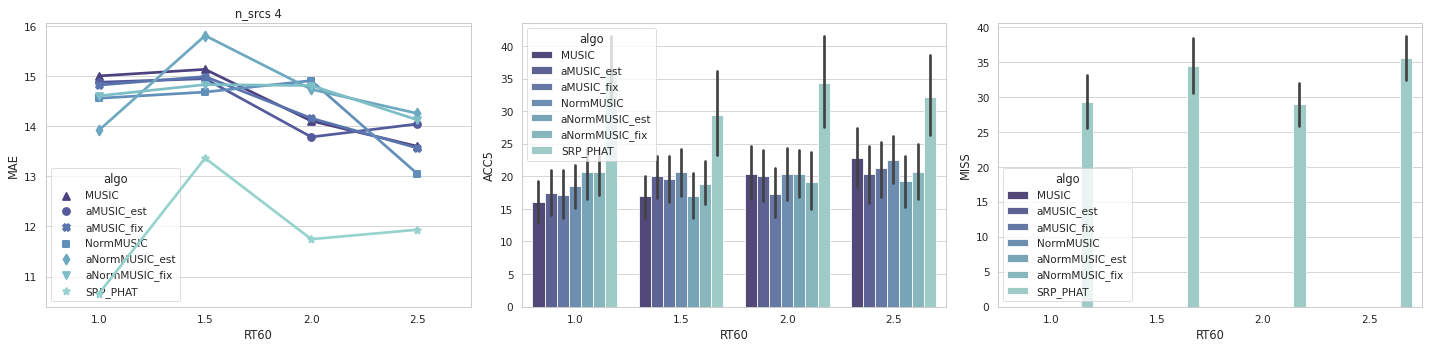

In [22]:
for n_srcs in [1,2,3,4]:
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f'n_srcs {n_srcs}')
    sns.pointplot(x='RT60', y='MAE', hue='algo', 
                  palette=pal,
                  data=df.loc[df['n_srcs'] == n_srcs],
                  markers=['^','o','X','s','d','v','*'],
                  ci=None
    )
    plt.subplot(132)
    sns.barplot(x='RT60', y='ACC5', hue='algo', 
                palette=pal,
                data=df.loc[df['n_srcs'] == n_srcs],
    )
    plt.subplot(133)
    sns.barplot(x='RT60', y='MISS', hue='algo', 
                palette=pal,
                data=df.loc[df['n_srcs'] == n_srcs],
    )
    
    plt.tight_layout()